# Training Deep Neural Networks

# A. The Vanishing/Exploding Gradients Problems:
* Generally, DNNs suffer from unstable gradients; different layers may learn at widely different speeds.
    * One of the few suspects is the combination of the sigmoid activation function and the weight initialization technique (normal distribution w/ mean=0, and std=1).  The variance of the outputs of each layer is much greater than the variance of its inputs. The variance keeps increasing after each layer until the activation function saturates at the top layers. When backpropagation kicks in it has virtually no gradient to propagate back through the network, and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers, so there is really nothing left for the lower layers.

* **Vanishing Gradients** Problem:
    * The backpropagation algorithm's 2nd phase works by going from the output layer to the input layer, propagating the error gradient along the way. Once the algorithm has computed the gradient of the cost function w/ regard to each parameter in the network, it uses these gradients to update each parameter w/ a gradient descent step.
    * Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the gradient descent update leaves the lower layers' connection weights virtually unchanged, and trainign never converges to a good solution.

* **Exploding Gradients** Problem:
    * The gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges.
    * Surfaces most often in recurrent neural networks.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

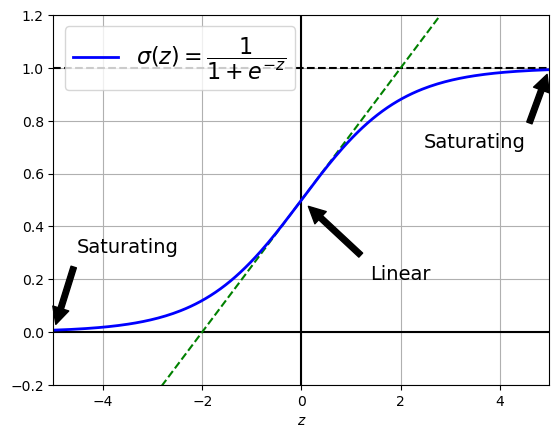

In [2]:
# Sigmoid Activation Function saturation:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16);

### A.1. Glorot and He Initialization:

* To alleviate the unstable gradients problem, the signal needs to flow properly in both directions: In the forward direction when making predictions, and in the reverse direction when backpropagating gradients.
    * The signal should not die out, nor explode and saturate. For the signal to flow properly:
        * The variance of the outputs of each layer should be equal to the variance of the inputs.
        * The gradients needs to have equal variance before and after flowing through a layer in the reverse direction.
    * It is actually not possible to guarantee both unless the layer has an equal number of inputs and outputs (*fan-in* and *fan-out* of the layer), but *Glorot* and *Bengio* proposed a good compromise:
        * The connection weights of each layer must be initialized randomly, **Glorot Initialization or Xaviar Initialization**: <br>
        &emsp; *when using the sigmoid activation function* <br>
        &emsp; Normal distribution w/ mean, $\mu$=0 and variance ,$\sigma^2=\frac{1}{fan_{avg}}$ <br>
        &emsp; Uniform distribution between $-r$ and $+r$, w/ $r\ =\ \sqrt{\frac{3}{fan_{avg}}}$ <br>
        &emsp; where $fan_{avg}\ =\ \frac{fan_{in}\ +\ fan_{out}}{2}$
        * Using Glorot Initialization can speed up training considerably.

    * **LeCun Initialization**:
        * Is equivalent to Glorot initialization when $fan_{in}\ =\ fan_{out}$

* Initialization parameters for each type of activation function: <br><br>
    &emsp; 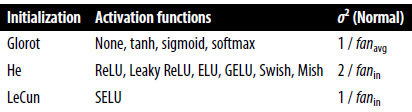

* By default, `Keras` uses Glorot initialization w/ a uniform distribution.
    * When creating a layer, you can switch to *He Initialization* by setting `kernel_initializer="he_uniform"` or `kernel_initializer="he_normal"`.
    * Alternatively, other initialization techniques can be obtained using the `VarianceScaling` initializer.

In [3]:
dense = tf.keras.layers.Dense(
    50,
    activation="relu",
    kernel_initializer="he_normal"
)

In [4]:
# Using the VarianceScaling class : Creating He Initialization w/ uniform distribution and based on fan_avg
he_avg_init = tf.keras.initializers.VarianceScaling(
    scale=2,
    mode="fan_avg", 
    distribution="uniform"
)

dense = tf.keras.layers.Dense(
    50,
    activation="sigmoid",
    kernel_initializer=he_avg_init
)

### A.2. Better Activation Functions:

* Poor choice of activation functions leads to unstable gradients.
* Other activation functions behave much better in deep neural networks, in particular the ReLU activation fuction, mostly because it does not saturate for positive values, and also because it is very fast to compute. Unfortunately, the ReLU suffers from a problem known as the *dying ReLUs*:
    * During training, some neurons effectively die. They stop outputting anything other than 0. In some cases, half of the network's neurons are dead, especially if you used a large learning rate.
    * A neuron dies when its weights get tweaked in such a way that the input of the ReLU is negative for all instances in the training set. When this happens, it just keeps outputting zeros, and gradient descent does not affect it anymore because the gradient of the ReLU function is zero when its input is negative.
        * A dead neuron may come back to life if its inputs evolve over time and eventually return w/in a range where the ReLU activation function gets a positive input again. For example, this may happen if gradient descent tweaks the neurons in the layers below the dead neuron.
    * Using a variant of the ReLU function, such as leaky ReLU, can solve this problem.

##### Leaky ReLU

* $LeakyReLU_{\alpha}(z)\ =\ max(\alpha z, z)$ : <br>
    * $\alpha$ = This hyperparameter defines how much the function leaks: it is the slope of the function for $z < 0$.
        * Having a slope for $z < 0$ ensures that leaky ReLUs never die.
    * Leaky Variants always outperformed the strict ReLU activation function.
        * Setting $\alpha\ =\ 0.2$ (large leak) seemed to result in better performance than $\alpha\ =\ 0.01$ (small leak).
    * Randmized Leaky ReLU (RReLU):
        * $\alpha$ is picked randomly in a given range during training and is fixed to an average during test.
        * Act as a regularizer, reducing the risk of overfitting the training set.
    * Parametric Leaky ReLU (PReLU):
        * $\alpha$ is authorized to be learned during training: instead of being a hyperparameter. It becomes a parameter that can be modified by backpropagation like any other parameter.
        * Strongly outperform ReLU on large image datasets, but on small dataset it runs the risk of overfitting the training set.

* ReLU, Leaky ReLU, and PReLU all suffer from the fact that they are not smooth functions:
    * Their derivatives abruptly change (at z = 0).
    * This sort of discontinuity can make gradient descent bounce around the optimum, and slow down convergence.

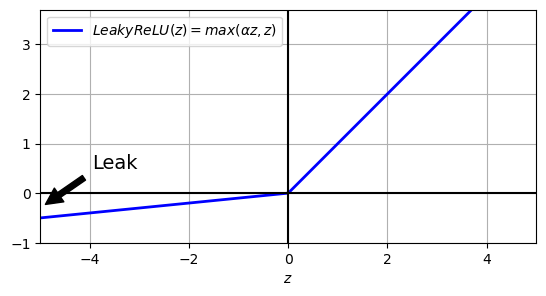

In [5]:
# Leaky ReLU 
def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend();

In [6]:
# implementing leaky rely in keras
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)
dense = tf.keras.layers.Dense(
    50,
    activation=leaky_relu,
    kernel_initializer="he_normal"
)

In [7]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
    # [...]  # more layers
])

In [8]:
# implementing PRelu in keras
parametric_relu = tf.keras.layers.PReLU()
dense = tf.keras.layers.Dense(
    50,
    activation=parametric_relu,
    kernel_initializer="he_normal"
)

In [9]:
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.PReLU(),  # activation as a separate layer
    # [...]  # more layers
])

##### Exponential Linear Unit (ELU) and Scaled Exponential Linear Unit (SELU):

* Exponential Linear Unit (ELU):
    * ELU Activation Function: <br>
    &emsp; $ELU_{\alpha}(z)\ =\begin{dcases} \mathrm{\alpha(exp(z)-1)\ if\ z\ <\ 0} \\ \mathrm{z\ if\ z\ \geq\ 0} \\  \end{dcases}$ <br>
    * ELU takes on negative values when z<0, w/c allows the unit to have an average output closer to 0 and helps alleviate the vanishing gradients problem.
        * The hyperparameter $\alpha$ defines the opposite of the value that the ELU function approaches when $z$ is a large negative number. It is usually set to 1, but you can tweak it like any other hyperparameter.
    * ELU has a nonzero gradient for z<0, w/c avoids the dead neurons problem.
    * If $\alpha$ is equal to 1 then the function is smooth everywhere, including around $z=0$, w/c helps speed up gradient descent since it does not bounce as much to the left and right of $z=0$.
    * `activation="elu"`, w/ `HE initialization`
    * Main drawback of ELU is that it is slower to compute than the ReLU function and its variants, due to the use of the exponential function. Its faster convergence rate during training may compensate for the slow computation, but still, at test time an ELU network will be a bit slower than a ReLU network.

* Scaled ELU (SELU):
    * Scaled variant of the ELU activation function (about 1.05 times ELU, using $\alpha\ \approx\ 1.67$).
    * `activation="selu"`.
    * If you build a neural network composed exclusively of a stack of dense layers (i.e., an MLP), and if all hidden layers use the SELU activation function, then the network will self-normalize: <br>
        * The output of each layer will tend to preserve a mean of 0 and a standard deviation of 1 during training, which solves the vanishing/exploding gradients problem.
    * For the self-normalization to happen:
        * The input features must be standardized: mean 0 and standard deviation 1.
        * Every hidden layer’s weights must be initialized using LeCun normal initialization. `kernel_initializer="lecun_normal"`
        * The self-normalizing property is only guaranteed with plain MLPs.
        * You cannot use regularization techniques like ℓ1 or ℓ2 regularization, max-norm, batch-norm, or regular dropout.

In [10]:
dense = tf.keras.layers.Dense(
    50,
    activation="elu",
    kernel_initializer="he_normal"
)

In [11]:
dense = tf.keras.layers.Dense(
    50,
    activation="selu",
    kernel_initializer="lecun_normal"
)

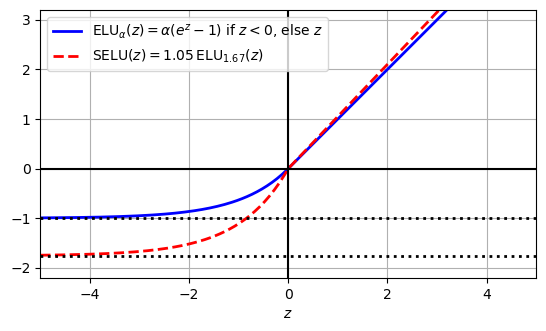

In [12]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend();

##### GELU, Swish, and Mish:

* **GELU (Gaussian Error Linear Units)**:
    * Smooth variant of the ReLU activation function.
    * GELU activation function: $GELU(z)\ =\ z\Phi(z)$, where:
        * $\Phi$ is the standard Guassian cumulative distribution function (CDF)
        * $\Phi(z)$ corresponds to the probability that a value sampled randomly from a normal distriution of mean=0 and variance=1 is lower than z.
        * GELU approaches 0 when its input z is very negative,and it approaches z when z is very positive.
        * GELU has a curvature at every point w/c makes it works so well, especially for complex tasks: Gradient descent may find it easier to fit complex patterns. However it is more computationlly intensive and the performance boost it provides is not always sufficient to justify the extra cost.
    * `activation="gelu"`.

* **Swish**:
    * Sigmoid Linear Unit (SiLU) activation function : $z\sigma(z)$.
        * `activation="swish"`
    * Generalized Swish : $Swish_\beta(z)\ =\ z\sigma(\beta z) $.
        * GELU is approximately equal to the generalized Swish function using $\beta$ = 1.702.
        * $\beta$ can be tuned like any hyperparameter. Alternatively, it's also possible to make $\beta$ trainable and let gradient descent optimize it, but it runs the risk of overfitting the data.

* **Mish**:
    * $Mish(z)\ =\ z\ tanh(softplus(z))$ where:
        * $softplus(z)\ =\ log(1\ +\ exp(z))$.
    * Smooth, nonconvex, and nonmonotonic variant of ReLU.
    * Mish overlaps almost perfectly w/ Swish when z is negative, and almost perfectly w/ GELU when z is positive.

* W/c activation function should you use for the hidden layers of your deep neural network?
    * ReLU remains a good defualt for a simple taks: it’s often just as good as the more sophisticated activation functions, plus it’s very fast to compute, and many libraries and hardware accelerators provide ReLU-specific optimizations.
    * However, Swish is probably a better default for more complex tasks, and you can even try parametrized Swish with a learnable β parameter for the most complex tasks.
    * Mish may give you slightly better results, but it requires a bit more compute. 
    * If you care a lot about runtime latency, then you may prefer leaky ReLU, or parametrized leaky ReLU for more complex tasks.
    * For deep MLPs, give SELU a try.
    * If you have spare time and computing power, you can use cross-validation to evaluate other activation functions as well.

* Other keras activations:
    * `tf.keras.activations...`
    * [Online Docs](https://www.tensorflow.org/api_docs/python/tf/keras/activations)

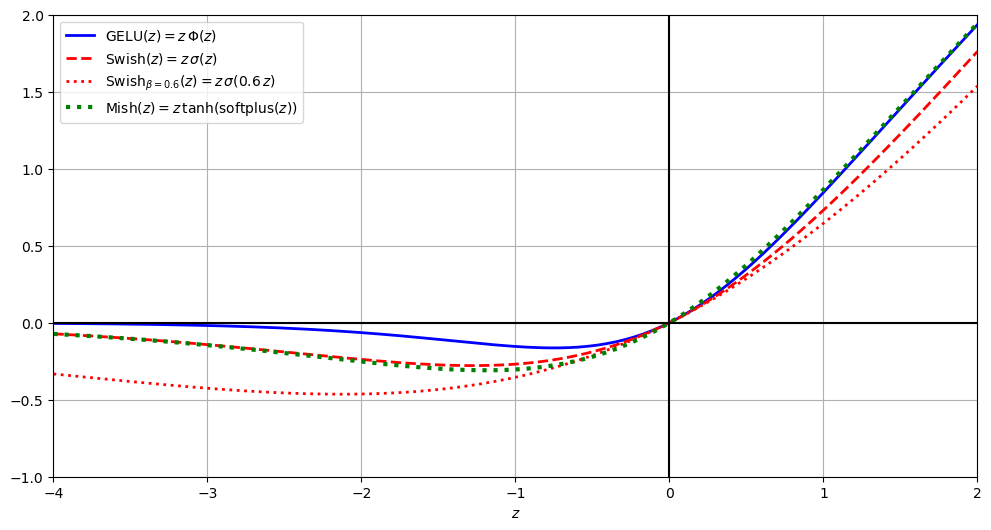

In [13]:
def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6

plt.figure(figsize=(12, 6))
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left");

### A.3. Batch Normalization:

* Using He initialization along with ReLU (or any of its variants) can significantly reduce the danger of the vanishing/exploding gradients problems at the beginning of training, it doesn’t guarantee that they won’t come back during training.

* **Batch Normalization (BN)**:
    * This technique consists of adding an operation in the model just before or after the activation function of each hidden layer. This operation zero-centers and normalizes each input, then scales and shifts the result using 2 new parameter vectors per layer: one for scaling, the other for shifting.
    * This operation lets the model learn the optimal scale and mean of each of the layer's inputs.
    * In many cases standardizing the training set is not needed when adding a BN layer as the 1st layer of a neural network.
    * In order to zero-center and normalize the inputs, the algorithm needs to estimate each input's mean and standard deviation. It does so by evaluating the mean and std of the input over the current mini-batch.

* **BN Algorithm**:
    1. $\mu_B\ =\large\ \frac{1}{m_B}\ \sum_{i=1}^{m_B}\ (x^{(i)})$:
        * $\mu_B$ = vector of input means, evaluated over the whole mini-batch, B. It contains one mean per input.
        * $m_B$ = number of instances in the mini-batch.
    2.  $\sigma_B^2\ =\large\ \frac{1}{m_B}\ \sum_{i=1}^{m_B}\ (x^{(i)}-\mu_B)^2$:
        * $\sigma_B$ = vector input standard deviations, evaluated over the whole mini-batch. It contains one std per input.
    3. $\hat{x}^{(i)}\ =\Large\  \frac{x^{(i)}-\mu_B}{\sqrt{\sigma_B^2\ +\ \varepsilon}}$:
        * $\hat{x}^{(i)}$ = vector of zero-centered and normalized inputs for instance i.
        * $\varepsilon$ = tiny number that avoids division by zero and ensures the gradients don't grow too large ( typically $10^{-5}$ ). This is called a *smoothing term*.
    4. $z^{(i)}\ =\ \gamma \bigotimes\ \hat{x}^{(i)}\ +\ \beta$:
        * $z^{(i)}$ = output of the BN operation. It is a rescaled and shifted version of the inputs.
        * $\gamma$ = output scale parameter vector for the layer. It contains one scale parameter per input.
        * $\bigotimes$ = element-wise multiplication. Each input is multiplied by its corresponding output scale parameter.
        * $\beta$ = output shift (offset) parameter for the layer. It contains one offset parameter per input. Each input is offset by its corresponding shift parameter.

* During  training, BN standardizes its inputs, then rescales and offsets them. But for test time,we may need to make predictions for individual instances rather than for batch instances, in this case we will have no way to compute each input's mean and standard deviation. Computing statistics over the batch instances would be unreliable. 
    * One solution could be to wait until the end of training, then run the whole training set through the neural network and compute the mean and standard deviation of each input of the BN layer. These “final” input means and standard deviations could then be used instead of the batch input means and standard deviations when making predictions. However, most implementations of batch normalization estimate these final statistics during training by using a moving average of the layer’s input means and standard deviations (ex. Keras' `BatchNormalization` layer.)
    * 4 parameter vectors are learned in each batch-normalized layer:
        * $\gamma$ = output scale vector learned through regular backpropagation
        * $\beta$ = output offset vector learned through regular backpropagation
        * $\mu$ = final input mean vector estimated using an exponential moving average.
        * $\sigma$ = final input std vector estimated using an exponential moving average.
    * $\mu$ and $\sigma$ are estimated during training, but they are used only after training to replace the batch input means and standard deviations.

* Batch normalization acts like a regulizer, reducing the need for other regularization techniques. Batch normalization does, however, add some complexity to the model. Moreover, there is a runtime penalty: the neural network makes slower predictions due to the extra computations required at each layer. Moreover, there is a runtime penalty: the neural network makes slower predictions due to the extra computations required at each layer.

* You may find that training is rather slow, because each epoch takes much more time when you use batch normalization. This is usually counterbalanced by the fact that convergence is much faster with BN, so it will take fewer epochs to reach the same performance. All in all, wall time will usually be shorter.

##### Implementing batch normalization with Keras:

* Add `BatchNormalization` layer before or after each hidden layer's activation function - as w/c is preferable depends on the task.
    * To add the BN layers before the activation function, you must remove the activation functions from the hidden layers and add them as separate layers after the BN layers.
    * Since a batch normalization layer includes one offset parameter per input, you can remove the bias term from the previous layer by passing `use_bias=False` when creating it.
    * Lastly, you can usually drop the first BN layer to avoid sandwiching the first hidden layer between two BN layers.
    
* You may also add a BN layer as the first layer in your model, but a plain `Normalization` layer generally performs just as well in this location (its only drawback is that you must first call its `adapt()` method).

* `BatchNormalization` important hyperparameters:
    * `momentum`:
        * hyperparameter used by the BN layer when it updates the EMA. 
        * Given a new value, **v**, the layer updates the running $\hat{v}$ using the equation: <br>
        &emsp; $\hat{v} \leftarrow\ \hat{v}\ x momentum\ + v\ x\ (1-momentum)$
        * A good momentum value is typically close to 1 (0.9, 0.99, 0.9999). You want more 9s for larger datasets and for smaller mini-batches.
    * `axis`:
        * It determines w/c axis should be normalized.
        * Default is -1. It will normalize the last axis (using the means and std computed across the other axes.)
        * When the input batch is 2D (i.e., the batch shape is [batch size, features]), this means that each input feature will be normalized based on the mean and standard deviation computed across all the instances in the batch.

* Batch normalization has become one of the most-used layers in deep neural networks, especially deep convolutional neural networks to the point that it is often omitted in the architecture diagrams: it is assumed that BN is added after every layer.

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [15]:
# Adding bn after each dense layer
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              4

In [17]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [18]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [19]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="sgd",
              metrics="accuracy"
)

model.fit(
    X_train, y_train, 
    epochs=2, 
    validation_data=(X_valid, y_valid)
)

Epoch 1/2
1719/1719 [==============================] - 16s 8ms/step - loss: 0.5486 - accuracy: 0.8110 - val_loss: 0.3935 - val_accuracy: 0.8568
Epoch 2/2
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4064 - accuracy: 0.8557 - val_loss: 0.3599 - val_accuracy: 0.8678


In [20]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [21]:
# Adding the batch normalization layer before each dense layer
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),

    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, 
          epochs=2, 
          validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 21s 11ms/step - loss: 0.6098 - accuracy: 0.7993 - val_loss: 0.4324 - val_accuracy: 0.8450
Epoch 2/2
1719/1719 [==============================] - 13s 7ms/step - loss: 0.4296 - accuracy: 0.8498 - val_loss: 0.3685 - val_accuracy: 0.8658


### A.4. Gradient Clipping:

* Gradient Clipping is another technique used to mitigate the exploding gradients problem. It clips the gradient during backpropagation so that they never exceed some threshold. 
    * Generally used in recurrent neural networks, where using batch normalization is tricky.

* In Keras, gradient clipping is implemented by setting the `clipvalue` or `clipnorm` argument when creating an optimizer.
    * All `tf.keras.optimizers` accept `clipnorm` or `clipvalue` arguments.
    * This optimizer will clip every component of the gradient vector to a value between -1.0 and 1.0. This means that all the partial derivatives of the loss (with regard to each and every trainable parameter) will be clipped between –1.0 and 1.0.
    * If you want to ensure that gradient clipping does not change the direction of the gradient vector, you should clip by norm by setting `clipnorm` instead of `clipvalue`. This will clip the whole gradient if its ℓ2 norm is greater than the threshold you picked.
    * If you observe that the gradients explode during training (you can track the size of the gradients using TensorBoard), you may want to try clipping by value or clipping by norm, with different thresholds, and see which option performs best on the validation set.

In [22]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer
)

In [23]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer
)